In [23]:
#numerico e dados
from tensorflow import keras
import numpy as np
import pandas as pd
from scipy.io import loadmat

#plots
import matplotlib.pyplot as plt

#Caminho
from pathlib import Path

#minhas bibliotecas
from normalization import *
from net import *

Dados que serão utilizando para o modelo prever

In [24]:
#importando .mat sem os dados de PH
path = Path('BD/DADOSsemPH.mat')
mat = loadmat(path)

In [25]:
#Criando uma variável para cada divisão de dado
Xt = mat['Xtrain']
yt = mat['ytrain']

Xts = mat['Xtest']
yts = mat['ytest']

In [26]:
# Normalizando os dados
Xtn = Normalize(Xt)
ytn = Normalize(yt)

Xtsn = Normalize(Xts)
ytsn = Normalize(yts)

Carregando o csv de testes

In [27]:
#Planilha dos testes
test_dataframe = pd.read_csv(Path('./test_dataframe.csv'))

In [28]:
last_test = test_dataframe['test'].iloc[-1]

Carregando o melhor modelo encontrado no Grid Search 

In [29]:
test_number = 4

In [30]:
#carregando a RNA
path_model = Path(f'./models/best_model{test_number}/model')
model = keras.models.load_model(path_model)

#carregando os hiperparametros
save_path = f'./models/best_model{test_number}'
hp_save_path = Path(save_path + '/hp')

#T, l, p, lbd, tau, hidden_neurons
with open(hp_save_path, 'rb') as f:
    _ = np.load(f).astype('int')
    l = np.load(f).astype('float')
    p = np.load(f).astype('float')
    lbd = np.load(f).astype('float')
    tau = np.load(f).astype('float')
    neurons = np.load(f)
    # epochs = np.load(f)


2022-08-02 12:14:32.859486: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-02 12:14:32.859642: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 12:14:32.861036: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Transformando o modelo RNA densamente conectada para RNA MC Dropout 

In [35]:
network = net(tau, p, l, ytsn.shape[0], neurons) #criando o objeto MC com os mesmos hiperparâmetros
network.model = model #carregando o modelo no objeto MC
network.epochs = 500 # network.epochs = epochs  

In [44]:
#fazendo previsões variando T
T = [50, 100, 1000, 10000, 100000]

#dataframe com os dados relativos a variação do T
T_dataframe = pd.DataFrame(columns=test_dataframe.columns)

for i, t in enumerate(T):
    network.MC_predict(Xtsn, ytsn, yts, t) 
    y_pred = network.pred
    y_inc = network.inc

    y_inc_perc = (y_inc/y_pred).mean()*100

    print(f"T={t} -> y_inc_perc = {y_inc_perc}")

    #salvando os melhores valores
    test_number = test_dataframe['test'].iloc[-1] + 1 + i
    values = [test_number, y_inc_perc, y_inc.mean(), network.RMSE, network.ll, t, l, network.p_dropout, network.lbd, network.tau, network.epochs, network.neurons[1]]
    new_row = pd.DataFrame([values], columns=test_dataframe.columns)

    #concatenando o novo dataframe
    T_dataframe = pd.concat([T_dataframe,new_row], ignore_index=True)

T_dataframe

T=50 -> y_inc_perc = 4.4579289853572845
T=100 -> y_inc_perc = 4.457948729395866
T=1000 -> y_inc_perc = 4.457920417189598
T=10000 -> y_inc_perc = 4.457903653383255
T=100000 -> y_inc_perc = 4.457913339138031


,test,incerteza(%),incerteza,RMSE,loglikelihood,T,l,p,lbd,tau,n_train,n_neuronios
0,13,4.457929,20.945316,0.401665,1.805304,50,0.0001,0.05,0.0,10000.0,500,50
1,14,4.457949,20.945383,0.572738,1.876786,100,0.0001,0.05,0.0,10000.0,500,50
2,15,4.45792,20.945389,1.805294,2.004012,1000,0.0001,0.05,0.0,10000.0,500,50
3,16,4.457904,20.945391,5.710027,2.04649,10000,0.0001,0.05,0.0,10000.0,500,50
4,17,4.457913,20.945393,18.059672,2.084974,100000,0.0001,0.05,0.0,10000.0,500,50


In [45]:
test_dataframe = pd.concat([test_dataframe,T_dataframe], ignore_index=True)
test_dataframe

,test,incerteza(%),incerteza,RMSE,loglikelihood,T,l,p,lbd,tau,n_train,n_neuronios
0,1,4.457764,20.945456,0.433674,0.602015,10,0.0001,0.05,0.0,50.0,10,50
1,2,4.46442,20.945423,0.422252,0.628116,10,0.0001,0.05,0.0,50.0,50,50
2,3,4.464185,20.945259,0.390646,0.734873,10,0.0001,0.05,0.0,100.0,100,50
3,4,4.457964,20.945108,0.178712,1.427133,10,0.0001,0.05,0.0,10000.0,500,50
4,5,4.467957,20.945631,0.433936,0.608812,10,0.0001,0.05,0.0,50.0,10,100
5,6,4.466501,20.945145,0.419739,0.627601,10,0.0001,0.05,0.0,50.0,50,100
6,7,4.467675,20.945177,0.390858,0.73237,10,0.0001,0.05,0.0,100.0,100,100
7,8,4.463146,20.944984,0.144207,0.999808,10,0.0001,0.05,0.0,50.0,500,100
8,9,4.466747,20.947113,0.468551,0.543367,10,0.0001,0.05,0.0,100.0,10,10
9,10,4.459739,20.945271,0.42338,0.62153,10,0.0001,0.05,0.0,50.0,50,10


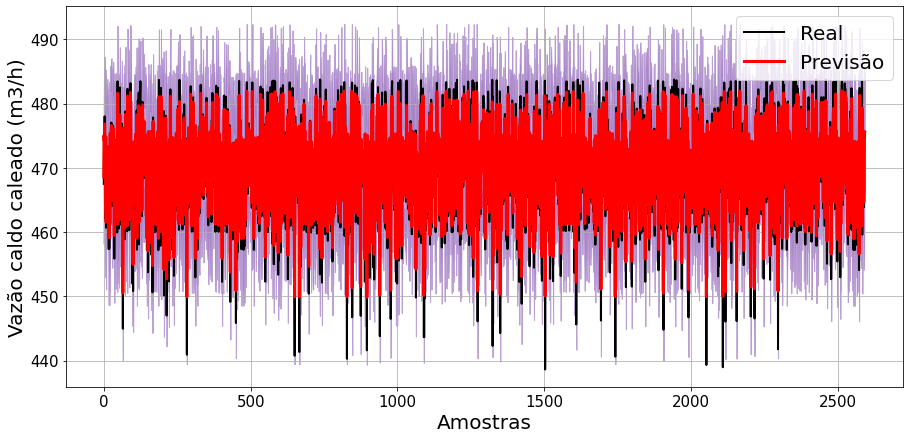

In [46]:
#figura da previsão com a adição da incerteza associada
fig2 = plt.figure(figsize=(15,7))

t = np.arange(y_pred.shape[0])

plt.plot(t, yts, color="black", label="Real", lw=2)
plt.plot(t, y_pred, color='red', label="Previsão", lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Amostras', fontsize=20)
plt.ylabel('Vazão caldo caleado (m3/h)', fontsize=20)

for shade in range(1,5):
  plt.fill_between(t, y_pred[:,0]+y_inc[:,0]/2, y_pred[:,0]-y_inc[:,0]/2, alpha=0.2, color='C4')

plt.grid(True)
plt.legend(fontsize=20)